# Model Training

This chapter is about how to train random forest models. With the tests conducted in the last section, we have the optimal values of the four main parameters that we will use in our SCA model. Our next step is to train the random forest model for SCA mapping.

#### 5.1 Split data into training and testing subsets
In this step, we split observations into a training subset and a testing subset. Usually, we want to use 70-80% of the data for training, and the remaining 70-80% of the data for testing. However, we find that the model accuracy is reaching a stable stage when the sample size reaches 4000 in the model parameter sensitivity analysis (Section 4.1). Therefore, we only use 4000 samples, with the remaining 96,000 samples used as an evaluation testing subset to improve model training efficiency.

We use the ‘train_test_split’ function from the ‘sklearn.model_selection’ module to randomly split the sample dataset into training and test subsets. 

The parameter ‘test_size’ can be float or integer. If it is a float, the value should be between 0.0 and 1.0, representing the proportion of the dataset to include in the test split. If it is an integer, it represents the absolute number of the train samples. 

The ‘random_state’ parameter is very useful for making the model sampling reproducible. Here, we assign ‘1’ to ‘random_state’. It does not matter what the actual ‘random_state’ number is. It could be any number, but the important thing is that every time we use ‘1’, just the same as the first time we make the split, we will get the same splits, which is very useful for the demonstration.


In [2]:
# read model input features and labels 
data = pd.read_csv('./data/samples/sample_100K.csv', index_col = False)
print("Sample dimentions:".format(), data.shape)
print(data.head())
X = data[['blue','green','red','nir']]
y = data['label']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.96,random_state=1)

Sample dimentions: (100000, 5)
     blue   green     red     nir  label
0  0.5948  0.4274  0.6514  0.6841      1
1  0.1088  0.1296  0.1580  0.2639      0
2  0.7735  0.5578  0.8296  0.7552      1
3  0.1581  0.1793  0.2152  0.2700      0
4  0.5916  0.4253  0.6499  0.6401      1


#### 5.2 Define the random forest model
Now, as we have the training subset and the optimal parameters, we can run the ‘RandomForestClassifier()’ to train our model using the code below:


In [3]:
# define the model
model = RandomForestClassifier(n_estimators=10, max_depth=10, max_features=4)

To evaluate the model performance, we conduct K-fold cross-validation using ‘RepeatedStratifiedKFold’ and ‘cross_val_score’ from ‘sklearn.model_selection’. Here, the training subset is randomly split into 10 folds evenly, and each fold is literally used to test the model which is trained by the remaining 9 folds of data. This process is repeated until each fold of the 10 folds has been used as the testing set. The average evaluation metric, here the ‘accuracy’, is used to represent the model performance. This whole process is repeated 1000 times to get the final model performance reported as below:


In [4]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1000)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# report model performance
print('Mean Score: %.6f (SD: %.6f)' % (n_scores.mean(),n_scores.std()))

Mean Score: 0.998049 (SD: 0.002128)


The overall model training accuracy is 0.998 with 0.002 standard deviation over the 1000 repeated cross-validations, indicating that only 0.2% of samples or pixels on average are incorrectly classified. If we look at the distribution of the accuracy values as shown below, most accuracy values are clustered near 1.00 and all values are higher than 0.98, indicating the model training is very precise and robust. 


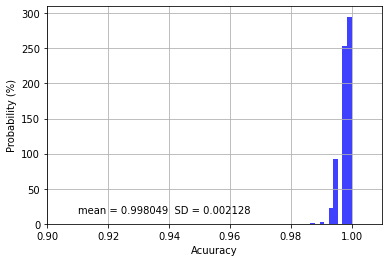

In [5]:
# the histogram of the scores
n, bins, patches = plt.hist(n_scores, density=True, facecolor='blue', alpha=0.75)
plt.text(0.91, 15, r'mean = ' + str(n_scores.mean().round(6)) + '  '+ 'SD = ' + str(n_scores.std().round(6)))
plt.xlim(0.9, 1.01)
plt.xlabel('Acuuracy')
plt.ylabel('Probability (%)')
plt.grid(True)
plt.show()

#### 5.3 Feature importance
It is important to explore each feature's importance, especially when the feature size is very large, and many features are redundant. In our case, it is not necessary to reduce feature size as we only have four features, but we want to know which band provides the most significant information in the SCA mapping. 

We use [‘permutation_importance’](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance) form ‘sklearn.inspection’ to estimate feature importance. The function of the permutation feature importance is described as [below](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance):

`The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature.`

As the random forest algorithm trains the model with randomly selected sample subsets and feature subsets, each model run would have a different estimate of feature importance. Thus, to get a robust estimate of feature importance, we repeated the process 1000 times as shown below. 
The result shows that the blue band provides the most important information for SCA mapping, while other three bands all show much less important.


Permutation importance - average: Index(['blue', 'green', 'red', 'nir'], dtype='object')
[0.504763, 0.000225, 0.002684, 0.000224]


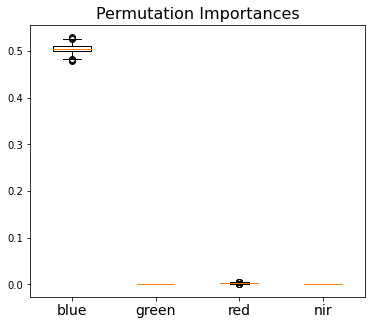

In [6]:
model.fit(X_train,y_train)
result = permutation_importance(model, X_train, y_train, n_repeats=1000, random_state=42, n_jobs=2)
print('Permutation importance - average:'.format(), X_train.columns)
print([round(i, 6) for i in result.importances_mean])

# displace feature importance
fig, ax = plt.subplots(figsize=(6,5))
ax.boxplot(result.importances.T)
ax.set_title("Permutation Importances", fontsize = 16)
ax.set_xticklabels(labels=X_train.columns, fontsize=14)
plt.show()

#### 5.4 Save the model
We now have our model trained and evaluated. We can save the model using the ‘dump()’ function from the ‘joblib’ package as shown below, so that next time when we want to apply this model, we do not have to run through the process mentioned ahead again. In the next section, we will discuss how we load this model and apply it to a satellite image.


In [7]:
# save model 
dir_model = "./models/random_forest_SCA_binary.joblib"
joblib.dump(model, dir_model)

['./models/random_forest_SCA_binary.joblib']